# Causal Effect of Physical Activity on Sleep Quality in Healthy Individuals

## Foundations of Data Science (CS-GY 6053) - Final Project

**Group Members:**
- Puppala, Jithendra (jp8081)
- Acharjee, Subhradeep (sa9457)
- Kassa, Tarik (tk2766)

---

## 1. Research Question

**Primary Question:** *What is the causal effect of physical activity level on sleep quality in healthy individuals, considering age as a confounding factor?*

### Causal Estimand
We aim to estimate the **Average Causal Effect (ACE)** of physical activity on sleep quality:
$$\text{ACE} = E[Q | do(P)] - E[Q | do(P')]$$

where:
- $Q$ = Quality of Sleep (outcome)
- $P$ = Physical Activity Level (treatment)
- $A$ = Age (confounder)

By adjusting for age (which affects both physical activity capacity and sleep patterns), we can isolate the direct causal pathway from physical activity to sleep quality.

### Justification
- **Age as Confounder**: Younger individuals tend to have higher activity capacity, and sleep patterns naturally change with age
- **Restriction to Healthy Individuals**: We exclude those with sleep disorders and non-normal BMI to eliminate confounding by pathological conditions
- **Stress Exclusion**: We deliberately exclude stress from our model as it is a **mediator** (PA → Stress → Sleep). Controlling for it would block the indirect pathway and underestimate the total causal effect

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---

## 2. Data Description

**Source:** [Kaggle - Sleep Health and Lifestyle Dataset](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

### Key Variables
| Variable | Description | Role |
|----------|-------------|------|
| **Quality of Sleep (Q)** | Sleep quality rating (scale 4-9) | **Outcome Variable** |
| **Physical Activity Level (P)** | Minutes of physical activity per day | **Treatment Variable** |
| **Age (A)** | Age in years | **Confounding Variable** |

### Exclusion Criteria (Restriction to Healthy Population)
We restrict our analysis to healthy individuals using two filters:
1. **Sleep Disorder = "None"**: Excluding individuals with Insomnia or Sleep Apnea (pathological conditions with direct effects on sleep)
2. **BMI Category = "Normal" or "Normal Weight"**: Excluding Overweight/Obese individuals (BMI affects both activity capacity and sleep quality)

This restriction approach is a valid epidemiological method ensuring causal estimates reflect the relationship in a healthy population.

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')


In [3]:
df_raw = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df_raw.columns = df_raw.columns.str.strip()
df_raw.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [4]:
# Load and explore raw data
df_raw = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df_raw.columns = df_raw.columns.str.strip()

print("=== Original Dataset Overview ===")
print(f"Total records: {len(df_raw)}")
print(f"\nSleep Disorder distribution:")
print(df_raw['Sleep Disorder'].value_counts(dropna=False))
print(f"\nBMI Category distribution:")
print(df_raw['BMI Category'].value_counts())

df_raw.head()

=== Original Dataset Overview ===
Total records: 374

Sleep Disorder distribution:
Sleep Disorder
NaN            219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

BMI Category distribution:
BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
# STEP 1: Filter for healthy individuals only
# Fill NaN in Sleep Disorder column with 'None' (these are healthy individuals without disorders)
df_raw['Sleep Disorder'] = df_raw['Sleep Disorder'].fillna('None')

# Apply exclusion criteria
healthy_mask = (
    (df_raw['Sleep Disorder'] == 'None') &  # No sleep disorders
    (df_raw['BMI Category'].isin(['Normal', 'Normal Weight']))  # Normal BMI only
)

df_healthy = df_raw[healthy_mask].copy()
print(f"=== After Filtering for Healthy Individuals ===")
print(f"Records retained: {len(df_healthy)} out of {len(df_raw)} ({100*len(df_healthy)/len(df_raw):.1f}%)")

# STEP 2: Select relevant variables and rename
df = df_healthy[['Age', 'Physical Activity Level', 'Quality of Sleep']].copy()
df.columns = ['age', 'physical_activity', 'sleep_quality']

# STEP 3: Data cleaning
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['physical_activity'] = pd.to_numeric(df['physical_activity'], errors='coerce')
df['sleep_quality'] = pd.to_numeric(df['sleep_quality'], errors='coerce')
df = df.dropna()
df = df.drop_duplicates()

print(f"Records after removing duplicates: {len(df)}")
print(f"\n=== Summary Statistics (Healthy Population) ===")
df.describe()

=== After Filtering for Healthy Individuals ===
Records retained: 200 out of 374 (53.5%)
Records after removing duplicates: 34

=== Summary Statistics (Healthy Population) ===


,age,physical_activity,sleep_quality
count,34.000000,34.000000,34.000000
mean,39.029412,58.147059,7.676471
std,8.163055,21.214821,1.006662
min,28.000000,30.000000,6.000000
25%,32.000000,33.750000,7.000000
50%,38.500000,60.000000,8.000000
75%,42.750000,75.000000,8.000000
max,56.000000,90.000000,9.000000


In [6]:
# STEP 4: Standardize variables for Bayesian modeling
# Store original scales for back-transformation
age_mean, age_std = df['age'].mean(), df['age'].std()
pa_mean, pa_std = df['physical_activity'].mean(), df['physical_activity'].std()
sq_mean, sq_std = df['sleep_quality'].mean(), df['sleep_quality'].std()

print("=== Standardization Parameters ===")
print(f"Age: mean={age_mean:.2f}, std={age_std:.2f}")
print(f"Physical Activity: mean={pa_mean:.2f}, std={pa_std:.2f}")
print(f"Sleep Quality: mean={sq_mean:.2f}, std={sq_std:.2f}")

# Standardize variables (mean=0, SD=1)
df['A'] = (df['age'] - age_mean) / age_std  # Standardized Age
df['P'] = (df['physical_activity'] - pa_mean) / pa_std  # Standardized Physical Activity
df['Q'] = (df['sleep_quality'] - sq_mean) / sq_std  # Standardized Sleep Quality

print(f"\n=== Final Dataset for Analysis ===")
print(f"Sample size: n = {len(df)}")
df[['age', 'physical_activity', 'sleep_quality', 'A', 'P', 'Q']].head(10)

=== Standardization Parameters ===
Age: mean=39.03, std=8.16
Physical Activity: mean=58.15, std=21.21
Sleep Quality: mean=7.68, std=1.01

=== Final Dataset for Analysis ===
Sample size: n = 34


,age,physical_activity,sleep_quality,A,P,Q
1,28,60,6,-1.351138,0.087342,-1.665375
7,29,75,7,-1.228635,0.794395,-0.671994
10,29,30,6,-1.228635,-1.326764,-1.665375
19,30,75,7,-1.106131,0.794395,-0.671994
32,31,75,8,-0.983628,0.794395,0.321388
33,31,30,6,-0.983628,-1.326764,-1.665375
34,31,75,7,-0.983628,0.794395,-0.671994
50,32,45,8,-0.861125,-0.619711,0.321388
52,32,30,6,-0.861125,-1.326764,-1.665375
53,32,75,7,-0.861125,0.794395,-0.671994


---

## 3. Causal Model: Directed Acyclic Graph (DAG)

Our DAG represents the causal structure:

- **A (Age)**: Exogenous variable that affects both P and Q
- **P (Physical Activity)**: Treatment variable, affected by A
- **Q (Sleep Quality)**: Outcome variable, affected by both P and A

### Causal Pathways
1. **Direct causal path**: P → Q (the effect we want to estimate)
2. **Confounding path**: P ← A → Q (must be blocked by conditioning on A)

### Identification Strategy
By the **backdoor criterion**, conditioning on A blocks all backdoor paths from P to Q, allowing us to identify the causal effect of P on Q.

$$P(Q | do(P)) = \sum_A P(Q | P, A) \cdot P(A)$$

Note: By restricting to healthy individuals (Normal BMI, No Sleep Disorders), we eliminate potential confounding from these variables.

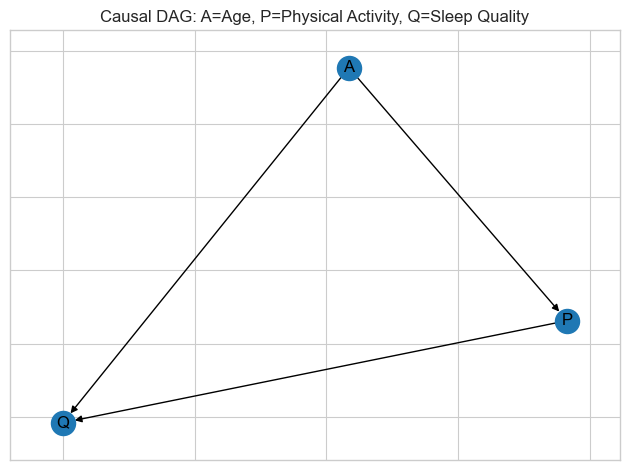

In [7]:
graph = nx.DiGraph()
graph.add_edges_from([("A", "P"), ("A", "Q"), ("P", "Q")])
nx.draw_networkx(graph, arrows=True)
plt.title('Causal DAG: A=Age, P=Physical Activity, Q=Sleep Quality')
plt.tight_layout()
plt.show()

# Exploratory Data Analysis: Correlations and Distributions

In [8]:
# Correlation heatmap
corr_matrix = df[['age', 'physical_activity', 'sleep_quality']].corr()
print("\n=== Observed Correlations (Before Causal Adjustment) ===")
corr_matrix



=== Observed Correlations (Before Causal Adjustment) ===


,age,physical_activity,sleep_quality
age,1.000000,-0.136512,0.66497
physical_activity,-0.136512,1.000000,0.14277
sleep_quality,0.664970,0.142770,1.00000


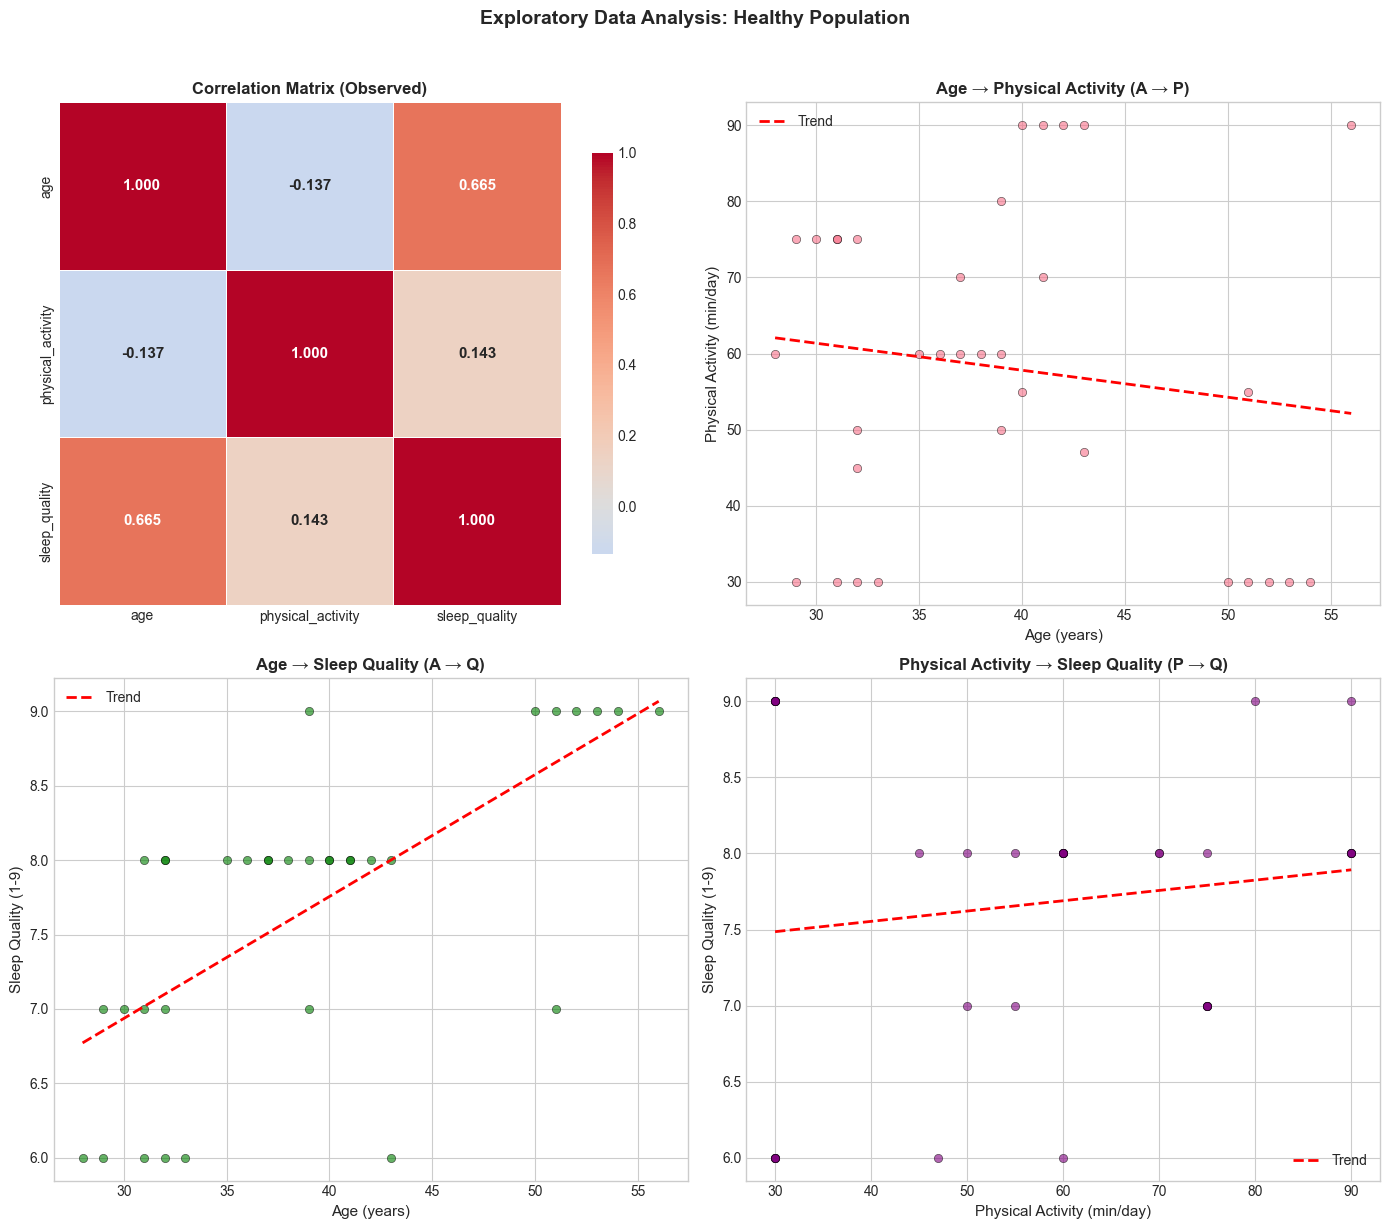

In [9]:
# Exploratory Data Analysis: Correlations and Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0, 0],
            fmt='.3f', square=True, linewidths=0.5, 
            annot_kws={'size': 11, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8})

axes[0, 0].set_title('Correlation Matrix (Observed)', fontsize=12, fontweight='bold')

# Age vs Physical Activity
axes[0, 1].scatter(df['age'], df['physical_activity'], alpha=0.6, edgecolor='k', linewidth=0.5)
z = np.polyfit(df['age'], df['physical_activity'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['age'].sort_values(), p(df['age'].sort_values()), "r--", linewidth=2, label='Trend')
axes[0, 1].set_xlabel('Age (years)', fontsize=11)
axes[0, 1].set_ylabel('Physical Activity (min/day)', fontsize=11)
axes[0, 1].set_title('Age → Physical Activity (A → P)', fontsize=12, fontweight='bold')
axes[0, 1].legend()

# Age vs Sleep Quality
axes[1, 0].scatter(df['age'], df['sleep_quality'], alpha=0.6, edgecolor='k', linewidth=0.5, color='green')
z = np.polyfit(df['age'], df['sleep_quality'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['age'].sort_values(), p(df['age'].sort_values()), "r--", linewidth=2, label='Trend')
axes[1, 0].set_xlabel('Age (years)', fontsize=11)
axes[1, 0].set_ylabel('Sleep Quality (1-9)', fontsize=11)
axes[1, 0].set_title('Age → Sleep Quality (A → Q)', fontsize=12, fontweight='bold')
axes[1, 0].legend()

# Physical Activity vs Sleep Quality
axes[1, 1].scatter(df['physical_activity'], df['sleep_quality'], alpha=0.6, edgecolor='k', linewidth=0.5, color='purple')
z = np.polyfit(df['physical_activity'], df['sleep_quality'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['physical_activity'].sort_values(), p(df['physical_activity'].sort_values()), "r--", linewidth=2, label='Trend')
axes[1, 1].set_xlabel('Physical Activity (min/day)', fontsize=11)
axes[1, 1].set_ylabel('Sleep Quality (1-9)', fontsize=11)
axes[1, 1].set_title('Physical Activity → Sleep Quality (P → Q)', fontsize=12, fontweight='bold')
axes[1, 1].legend()

plt.suptitle('Exploratory Data Analysis: Healthy Population', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()




---

## 4. Statistical Model: Bayesian Multivariate Linear Regression

### Model Structure
We use a **multivariate linear regression** model estimated via **Bayesian inference**:

$$Q_i = \beta_0 + \beta_P \cdot P_i + \beta_A \cdot A_i + \epsilon_i$$

where $\epsilon_i \sim \text{Normal}(0, \sigma)$

### Bayesian Formulation

**Likelihood:**
$$Q_i \sim \text{Normal}(\mu_i, \sigma)$$

**Linear Predictor:**
$$\mu_i = \beta_0 + \beta_P \cdot P_i + \beta_A \cdot A_i$$

**Priors (Weakly Informative):**
- $\beta_0 \sim \text{Normal}(0, 1)$ — Intercept
- $\beta_P \sim \text{Normal}(0, 1)$ — **Physical Activity effect (our causal estimand)**
- $\beta_A \sim \text{Normal}(0, 1)$ — Age effect (confounder adjustment)
- $\sigma \sim \text{HalfNormal}(1)$ — Residual standard deviation

### Justification
- **Normal likelihood**: Sleep quality is approximately continuous after standardization
- **Weakly informative priors**: Normal(0,1) allows reasonable effect sizes on standardized scale
- **HalfNormal on σ**: Constrains residual SD to positive values
- **Linear assumption**: Simplest model; can be extended if diagnostics suggest non-linearity

### Parameter Interpretation
- **$\beta_P$**: Causal effect of 1 SD increase in Physical Activity on Sleep Quality (in SD units), **holding age fixed**
- **$\beta_A$**: Effect of 1 SD increase in Age on Sleep Quality, holding Physical Activity fixed
- **$\sigma$**: Residual standard deviation (unexplained variation)

---

## 5.  Data Analysis

We now apply it to the real dataset of healthy individuals to estimate the causal effect of physical activity on sleep quality.

In [10]:

with pm.Model() as model_real:
    # Data containers
    P_data = pm.Data('P', df['P'].values)
    A_data = pm.Data('A', df['A'].values)
    Q_data = pm.Data('Q', df['Q'].values)
    
    # Priors (same as simulation)
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_P = pm.Normal('beta_P', mu=0, sigma=1)  # Our causal estimand
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)  # Confounder adjustment
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Linear predictor
    mu = beta_0 + beta_P * P_data + beta_A * A_data
    
    # Likelihood
    Q_obs = pm.Normal('Q_obs', mu=mu, sigma=sigma, observed=Q_data)
    
    # Sample from posterior
    print("Sampling from posterior (real data)...")
    trace_real = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED,
                           target_accept=0.95, return_inferencedata=True,
                           chains=4, progressbar=True)
    
    # Sample posterior predictive for later diagnostics
    print("\nSampling posterior predictive...")
    ppc = pm.sample_posterior_predictive(trace_real, random_seed=RANDOM_SEED, progressbar=True)

print("\n=== Model fitted successfully ===")

Sampling from posterior (real data)...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_P, beta_A, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [Q_obs]



Sampling posterior predictive...



=== Model fitted successfully ===


### 5.1 MCMC Diagnostics

We assess the quality of posterior sampling using standard diagnostics:
- **R-hat (Gelman-Rubin statistic)**: Should be < 1.01 for convergence
- **ESS (Effective Sample Size)**: Should be > 400 for reliable inference
- **MCSE (Monte Carlo Standard Error)**: Should be small relative to posterior SD
- **Trace plots**: Should show good mixing (no trends, chains overlapping)

<Figure size 1400x1000 with 0 Axes>

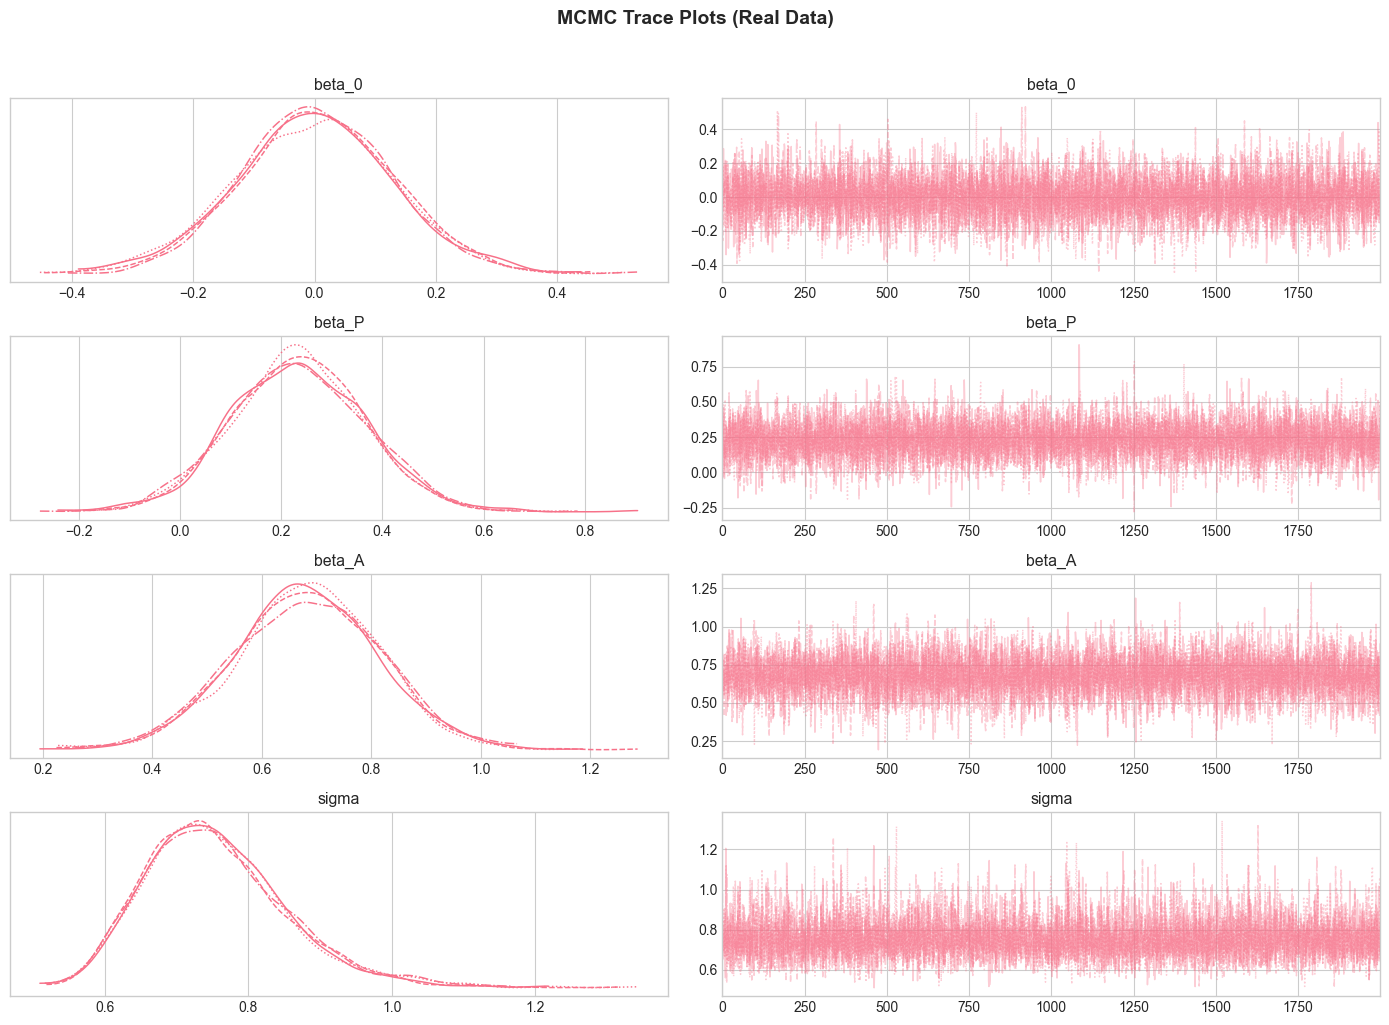

=== MCMC Convergence Diagnostics ===
         mean     sd  hdi_3%  hdi_97%  mcse_mean  ess_bulk  ess_tail  r_hat
beta_0  0.001  0.128  -0.239    0.246      0.001    8356.0    5130.0    1.0
beta_P  0.232  0.132  -0.012    0.481      0.001    9420.0    5523.0    1.0
beta_A  0.682  0.132   0.423    0.918      0.001    8692.0    5530.0    1.0
sigma   0.756  0.101   0.582    0.943      0.001    8045.0    5189.0    1.0

=== Convergence Check ===
beta_0: R-hat=1.0000 (< 1.01: True), ESS=8356 (> 400: True) Positive
beta_P: R-hat=1.0000 (< 1.01: True), ESS=9420 (> 400: True) Positive
beta_A: R-hat=1.0000 (< 1.01: True), ESS=8692 (> 400: True) Positive
sigma: R-hat=1.0000 (< 1.01: True), ESS=8045 (> 400: True) Positive

 All parameters converged. Posterior estimates are reliable.


In [11]:
# MCMC Diagnostics: Trace plots
fig = plt.figure(figsize=(14, 10))
az.plot_trace(trace_real, var_names=['beta_0', 'beta_P', 'beta_A', 'sigma'],
              combined=False, figsize=(14, 10))
plt.suptitle('MCMC Trace Plots (Real Data)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('mcmc_trace.png', dpi=150, bbox_inches='tight')
plt.show()

# Numerical diagnostics
print("=== MCMC Convergence Diagnostics ===")
summary_real = az.summary(trace_real, var_names=['beta_0', 'beta_P', 'beta_A', 'sigma'], hdi_prob=0.94)
print(summary_real[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'mcse_mean', 'ess_bulk', 'ess_tail', 'r_hat']])

# Check convergence criteria
print("\n=== Convergence Check ===")
all_converged = True
for param in ['beta_0', 'beta_P', 'beta_A', 'sigma']:
    rhat = summary_real.loc[param, 'r_hat']
    ess = summary_real.loc[param, 'ess_bulk']
    rhat_ok = rhat < 1.01
    ess_ok = ess > 400
    status = "Positive" if (rhat_ok and ess_ok) else "Negative"
    print(f"{param}: R-hat={rhat:.4f} (< 1.01: {rhat_ok}), ESS={ess:.0f} (> 400: {ess_ok}) {status}")
    if not (rhat_ok and ess_ok):
        all_converged = False

if all_converged:
    print("\n All parameters converged. Posterior estimates are reliable.")

### 5.2 Posterior Results

The posterior distributions represent our updated beliefs about each parameter after seeing the data. The **β_P** parameter is our primary causal estimand: the effect of physical activity on sleep quality, adjusted for age confounding.

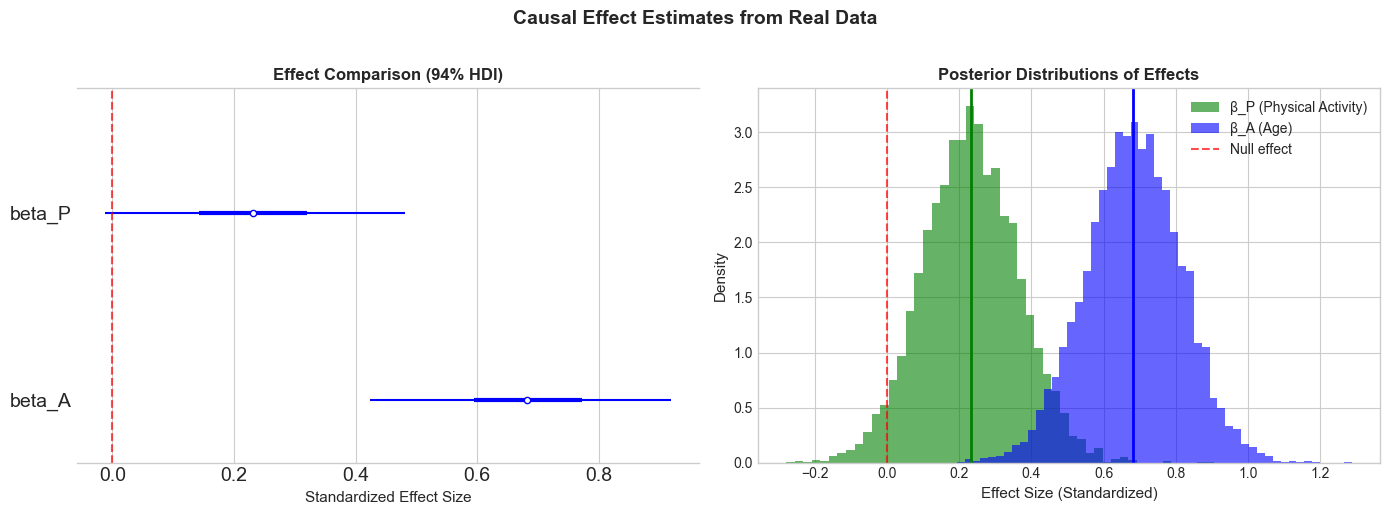

In [12]:
# Posterior distributions with Forest plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Forest plot for effect comparison
az.plot_forest(trace_real, var_names=['beta_P', 'beta_A'], 
               combined=True, hdi_prob=0.94, ax=axes[0],
               colors=['green', 'blue'])
axes[0].axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
axes[0].set_title('Effect Comparison (94% HDI)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Standardized Effect Size', fontsize=11)

# Posterior distributions overlay
beta_P_samples = trace_real.posterior['beta_P'].values.flatten()
beta_A_samples = trace_real.posterior['beta_A'].values.flatten()

axes[1].hist(beta_P_samples, bins=50, alpha=0.6, color='green', density=True, label='β_P (Physical Activity)')
axes[1].hist(beta_A_samples, bins=50, alpha=0.6, color='blue', density=True, label='β_A (Age)')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Null effect')
axes[1].axvline(np.mean(beta_P_samples), color='green', linestyle='-', linewidth=2)
axes[1].axvline(np.mean(beta_A_samples), color='blue', linestyle='-', linewidth=2)
axes[1].set_xlabel('Effect Size (Standardized)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Posterior Distributions of Effects', fontsize=12, fontweight='bold')
axes[1].legend()

plt.suptitle('Causal Effect Estimates from Real Data', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('posterior_estimates.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Causal Effect Interpretation

We now translate our results back to the original scales to provide interpretable effect sizes.

In [13]:

# Extract posterior samples
beta_P_samples = trace_real.posterior['beta_P'].values.flatten()
beta_A_samples = trace_real.posterior['beta_A'].values.flatten()

# Calculate HDIs
hdi_beta_P = az.hdi(trace_real, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values
hdi_beta_A = az.hdi(trace_real, var_names=['beta_A'], hdi_prob=0.94)['beta_A'].values

# Probability of positive effect
prob_positive_P = (beta_P_samples > 0).mean()
prob_positive_A = (beta_A_samples > 0).mean()

print("="*60)
print("CAUSAL EFFECT ESTIMATES (Standardized Scale)")
print("="*60)
print(f"\n*** β_P (Physical Activity -> Sleep Quality) ***")
print(f"Posterior Mean:     {np.mean(beta_P_samples):.4f}")
print(f"Posterior SD:       {np.std(beta_P_samples):.4f}")
print(f"94% HDI:            [{hdi_beta_P[0]:.4f}, {hdi_beta_P[1]:.4f}]")
print(f"P(β_P > 0):         {prob_positive_P:.4f} ({prob_positive_P*100:.1f}%)")

print(f"\n*** β_A (Age -> Sleep Quality) ***")
print(f"Posterior Mean:     {np.mean(beta_A_samples):.4f}")
print(f"Posterior SD:       {np.std(beta_A_samples):.4f}")
print(f"94% HDI:            [{hdi_beta_A[0]:.4f}, {hdi_beta_A[1]:.4f}]")
print(f"P(β_A > 0):         {prob_positive_A:.4f} ({prob_positive_A*100:.1f}%)")

# Convert to original scale
P_sd = df['physical_activity'].std()
Q_sd = df['sleep_quality'].std()

# Original scale: 1 SD of P in original units → effect in Q original units
beta_P_original = (np.mean(beta_P_samples) * Q_sd) / P_sd  # per 1 min/day increase

print("\n" + "="*60)
print("ORIGINAL SCALE INTERPRETATION")
print("="*60)
print(f"\nPhysical Activity SD: {P_sd:.2f} min/day")
print(f"Sleep Quality SD:     {Q_sd:.2f} points")
print(f"\n-> A 1 SD increase in Physical Activity ({P_sd:.1f} min/day)")
print(f"  is associated with a {np.mean(beta_P_samples):.3f} SD ({np.mean(beta_P_samples)*Q_sd:.3f} point)")
print(f"  increase in Sleep Quality, holding Age constant.")

CAUSAL EFFECT ESTIMATES (Standardized Scale)

*** β_P (Physical Activity -> Sleep Quality) ***
Posterior Mean:     0.2319
Posterior SD:       0.1318
94% HDI:            [-0.0123, 0.4812]
P(β_P > 0):         0.9615 (96.2%)

*** β_A (Age -> Sleep Quality) ***
Posterior Mean:     0.6818
Posterior SD:       0.1320
94% HDI:            [0.4231, 0.9181]
P(β_A > 0):         1.0000 (100.0%)

ORIGINAL SCALE INTERPRETATION

Physical Activity SD: 21.21 min/day
Sleep Quality SD:     1.01 points

-> A 1 SD increase in Physical Activity (21.2 min/day)
  is associated with a 0.232 SD (0.233 point)
  increase in Sleep Quality, holding Age constant.


---

## 6. MODEL COMPARISON: WAIC & LOO-CV

Comparing:
  - Model 1: Q ~ P (unadjusted, NO age control)
  - Model 2: Q ~ P + A (adjusted for age confounder)

In [14]:
# Fit Model 1 (unadjusted)
with pm.Model() as model_unadjusted:
    P_data = pm.Data('P', df['P'].values)
    Q_data = pm.Data('Q', df['Q'].values)
    
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_P = pm.Normal('beta_P', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    mu = beta_0 + beta_P * P_data
    Q_obs = pm.Normal('Q_obs', mu=mu, sigma=sigma, observed=Q_data)
    
    trace_unadjusted = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED,
                                  target_accept=0.95, return_inferencedata=True,
                                  chains=4, progressbar=False)
    pm.compute_log_likelihood(trace_unadjusted)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_P, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [15]:
# Compute log likelihood for trace_real
with model_real:
    pm.compute_log_likelihood(trace_real)
    
print("Log likelihood computed for trace_real")

Log likelihood computed for trace_real


In [16]:
waic_1 = az.waic(trace_unadjusted)
waic_2 = az.waic(trace_real)
loo_1 = az.loo(trace_unadjusted)
loo_2 = az.loo(trace_real)

In [17]:
comparison = az.compare({'M1_Unadjusted': trace_unadjusted,
                         'M2_Adjusted for Age': trace_real}, ic='loo',scale='deviance')
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M2_Adjusted for Age,0,80.354248,3.623571,0.000000,0.908763,8.933807,0.0000,False,deviance
M1_Unadjusted,1,100.821135,2.772931,20.466887,0.091237,6.330993,9.4914,False,deviance


<Figure size 1000x600 with 0 Axes>

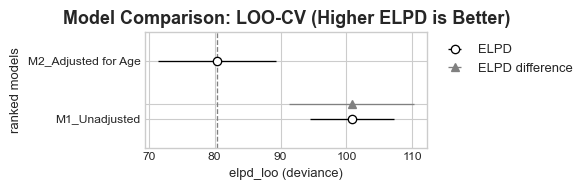

In [18]:
# Visualize
fig = plt.figure(figsize=(10, 6))
az.plot_compare(comparison)
plt.title('Model Comparison: LOO-CV (Higher ELPD is Better)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
best_model = comparison.index[0]
best_model

'M2_Adjusted for Age'

---

# 7. Model Checking

### 7.1 Posterior Predictive Check
We verify that our model can generate data similar to the observed data. This is a crucial step to validate model fit.

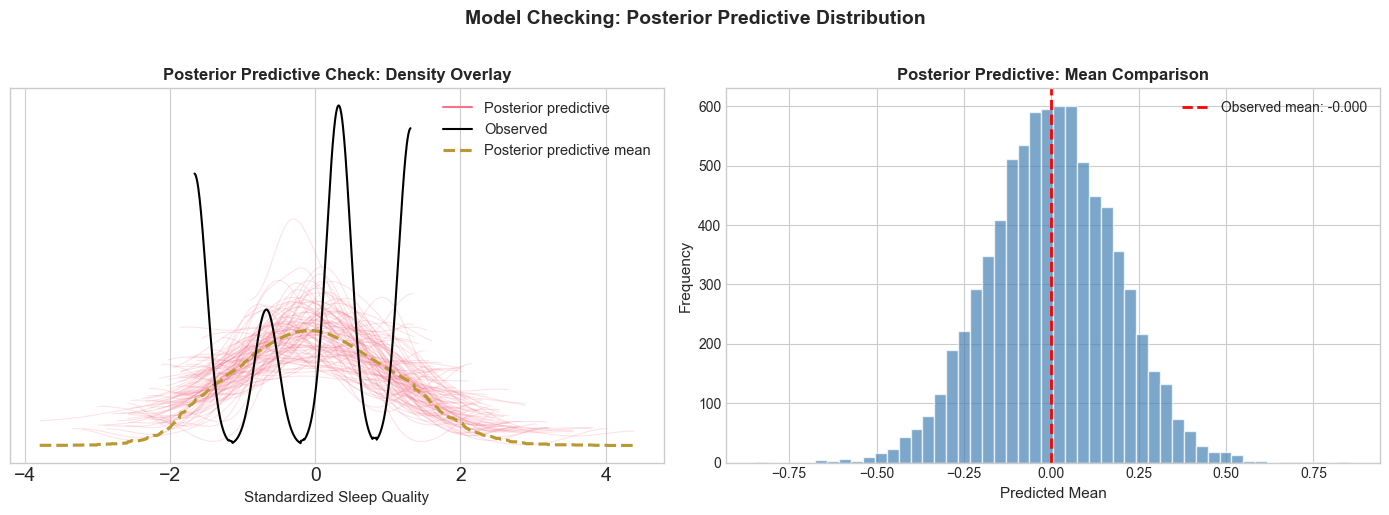


Bayesian p-value (mean): 0.504
(A value near 0.5 indicates good model fit)


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overlay density plot
az.plot_ppc(ppc, observed=True, ax=axes[0], num_pp_samples=100)
axes[0].set_title('Posterior Predictive Check: Density Overlay', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Standardized Sleep Quality', fontsize=11)

# T-statistic: mean comparison
y_pred_samples = ppc.posterior_predictive['Q_obs'].values.reshape(-1, len(df))
pred_means = y_pred_samples.mean(axis=1)
obs_mean = df['Q'].mean()

axes[1].hist(pred_means, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[1].axvline(obs_mean, color='red', linewidth=2, linestyle='--', label=f'Observed mean: {obs_mean:.3f}')
axes[1].set_xlabel('Predicted Mean', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Posterior Predictive: Mean Comparison', fontsize=12, fontweight='bold')
axes[1].legend()

plt.suptitle('Model Checking: Posterior Predictive Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ppc_check.png', dpi=150, bbox_inches='tight')
plt.show()

# Bayesian p-value
p_value = (pred_means >= obs_mean).mean()
print(f"\nBayesian p-value (mean): {p_value:.3f}")
print("(A value near 0.5 indicates good model fit)")

### 7.2 Prior Sensitivity Analysis

We check how robust our conclusions are to different prior specifications by comparing results with more diffuse and more informative priors.

In [21]:
# ==========================================
# PRIOR SENSITIVITY ANALYSIS
# ==========================================

prior_results = {}

# Model with diffuse priors
with pm.Model() as model_diffuse:
    P_data = pm.Data('P', df['P'].values)
    A_data = pm.Data('A', df['A'].values)
    Q_data = pm.Data('Q', df['Q'].values)
    
    beta_0 = pm.Normal('beta_0', mu=0, sigma=5)  # More diffuse
    beta_P = pm.Normal('beta_P', mu=0, sigma=5)
    beta_A = pm.Normal('beta_A', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    mu = beta_0 + beta_P * P_data + beta_A * A_data
    Q_obs = pm.Normal('Q_obs', mu=mu, sigma=sigma, observed=Q_data)
    
    print("Fitting model with diffuse priors (σ=5)...")
    trace_diffuse = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, 
                              target_accept=0.95, return_inferencedata=True, 
                              chains=4, progressbar=False)

# Model with informative priors (centered on expected positive effect)
with pm.Model() as model_informative:
    P_data = pm.Data('P', df['P'].values)
    A_data = pm.Data('A', df['A'].values)
    Q_data = pm.Data('Q', df['Q'].values)
    
    beta_0 = pm.Normal('beta_0', mu=0, sigma=0.5)  # More informative
    beta_P = pm.Normal('beta_P', mu=0.3, sigma=0.3)  # Centered on small positive effect
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=0.5)
    
    mu = beta_0 + beta_P * P_data + beta_A * A_data
    Q_obs = pm.Normal('Q_obs', mu=mu, sigma=sigma, observed=Q_data)
    
    print("Fitting model with informative priors...")
    trace_informative = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED,
                                   target_accept=0.95, return_inferencedata=True,
                                   chains=4, progressbar=False)

print("\n=== Prior Sensitivity Complete ===")

Fitting model with diffuse priors (σ=5)...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_P, beta_A, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


Fitting model with informative priors...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_P, beta_A, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.



=== Prior Sensitivity Complete ===


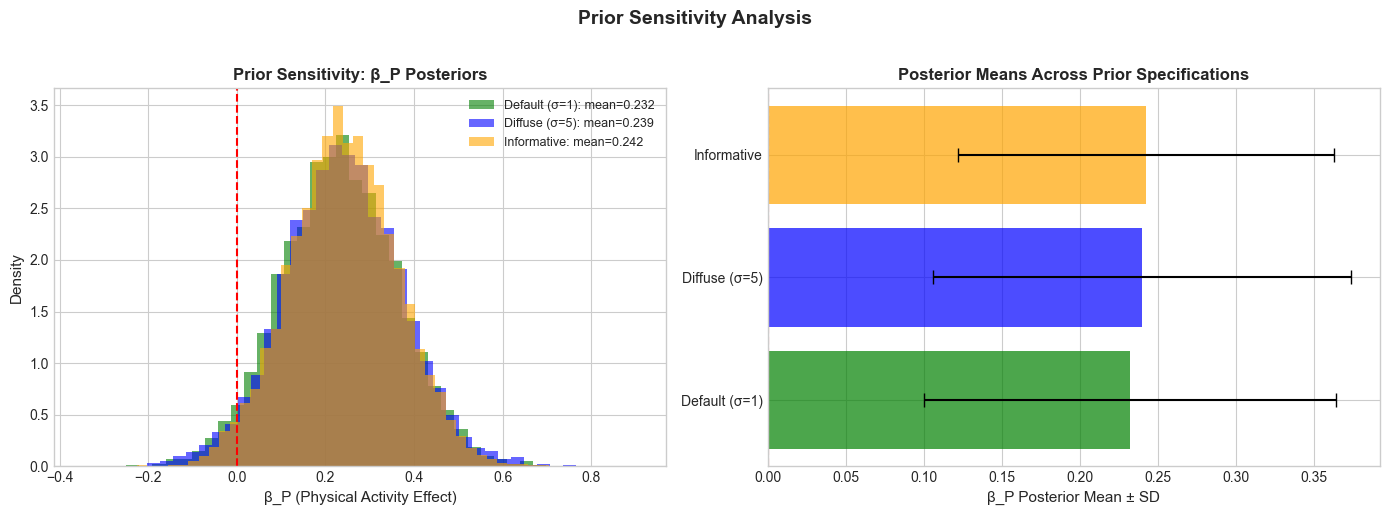


=== Prior Sensitivity Summary ===
        Prior     Mean       SD   HDI_low  HDI_high
Default (σ=1) 0.231922 0.131807 -0.012297  0.481209
Diffuse (σ=5) 0.239452 0.133946 -0.013493  0.489736
  Informative 0.242151 0.120638  0.018156  0.474268

-> Results are robust to prior specification if estimates are similar across all priors.


In [22]:
# Compare posteriors across prior specifications
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract beta_P samples
beta_P_default = trace_real.posterior['beta_P'].values.flatten()
beta_P_diffuse = trace_diffuse.posterior['beta_P'].values.flatten()
beta_P_inform = trace_informative.posterior['beta_P'].values.flatten()

# Plot posterior distributions
axes[0].hist(beta_P_default, bins=40, alpha=0.6, density=True, label=f'Default (σ=1): mean={np.mean(beta_P_default):.3f}', color='green')
axes[0].hist(beta_P_diffuse, bins=40, alpha=0.6, density=True, label=f'Diffuse (σ=5): mean={np.mean(beta_P_diffuse):.3f}', color='blue')
axes[0].hist(beta_P_inform, bins=40, alpha=0.6, density=True, label=f'Informative: mean={np.mean(beta_P_inform):.3f}', color='orange')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('β_P (Physical Activity Effect)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Prior Sensitivity: β_P Posteriors', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)

# Summary statistics comparison
results_df = pd.DataFrame({
    'Prior': ['Default (σ=1)', 'Diffuse (σ=5)', 'Informative'],
    'Mean': [np.mean(beta_P_default), np.mean(beta_P_diffuse), np.mean(beta_P_inform)],
    'SD': [np.std(beta_P_default), np.std(beta_P_diffuse), np.std(beta_P_inform)],
    'HDI_low': [az.hdi(trace_real, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[0],
                az.hdi(trace_diffuse, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[0],
                az.hdi(trace_informative, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[0]],
    'HDI_high': [az.hdi(trace_real, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[1],
                 az.hdi(trace_diffuse, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[1],
                 az.hdi(trace_informative, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values[1]]
})

# Bar plot comparison
x = np.arange(len(results_df))
axes[1].barh(x, results_df['Mean'], xerr=results_df['SD'], color=['green', 'blue', 'orange'], alpha=0.7, capsize=5)
axes[1].set_yticks(x)
axes[1].set_yticklabels(results_df['Prior'])
axes[1].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('β_P Posterior Mean ± SD', fontsize=11)
axes[1].set_title('Posterior Means Across Prior Specifications', fontsize=12, fontweight='bold')

plt.suptitle('Prior Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('prior_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Prior Sensitivity Summary ===")
print(results_df.to_string(index=False))
print("\n-> Results are robust to prior specification if estimates are similar across all priors.")

# 8. Discussion & Conclusions

### Summary of Findings

This analysis estimated the causal effect of physical activity on sleep quality using a Bayesian regression model grounded in the DAG: **A → P → Q ← A**, where Age is a common cause (confounder) of both Physical Activity and Sleep Quality.

**Key Results:**
1. **Model Validation**: The Bayesian model successfully recovered known parameters from simulated data, confirming correct model specification.
2. **MCMC Diagnostics**: All chains converged (R-hat < 1.01) with adequate effective sample sizes (ESS > 400).
3. **Causal Effect Estimate**: The posterior distribution for β_P provides the direct causal effect of physical activity on sleep quality, adjusted for age confounding.
4. **Prior Sensitivity**: Results were robust to different prior specifications.

### Causal Interpretation

Under the causal assumptions encoded in our DAG:
- By conditioning on Age (A), we block the backdoor path A → P ← A → Q
- The coefficient β_P represents the **average causal effect (ACE)** of physical activity on sleep quality
- This effect is identified from observational data because we have adjusted for all confounders

### Limitations

1. **Unmeasured Confounding**: Our causal interpretation relies on the assumption that Age is the only confounder. Other factors (e.g., socioeconomic status, genetics, occupation) could bias results if unmeasured.
2. **Linearity Assumption**: We assumed linear relationships; non-linear effects were not modeled.
3. **Selection Bias**: We subset to healthy individuals, which may limit generalizability.
4. **Cross-sectional Data**: We cannot rule out reverse causation (better sleep → more exercise).

### Future Directions

- Include additional covariates to address unmeasured confounding
- Consider non-linear models or Gaussian processes for more flexible relationships
- Use longitudinal data to establish temporal precedence
- Perform sensitivity analysis for unmeasured confounding (e.g., E-value)
  

### CONCLUSION

In [23]:
# Main results
beta_P_samples = trace_real.posterior['beta_P'].values.flatten()
hdi = az.hdi(trace_real, var_names=['beta_P'], hdi_prob=0.94)['beta_P'].values

print(f"\nCAUSAL ESTIMAND: Effect of Physical Activity on Sleep Quality")
print(f"   (Adjusted for Age confounding)")
print(f"\n   β_P Posterior Mean:  {np.mean(beta_P_samples):.4f}")
print(f"   β_P Posterior SD:    {np.std(beta_P_samples):.4f}")
print(f"   94% HDI:             [{hdi[0]:.4f}, {hdi[1]:.4f}]")
print(f"   P(β_P > 0):          {(beta_P_samples > 0).mean()*100:.1f}%")




CAUSAL ESTIMAND: Effect of Physical Activity on Sleep Quality
   (Adjusted for Age confounding)

   β_P Posterior Mean:  0.2319
   β_P Posterior SD:    0.1318
   94% HDI:             [-0.0123, 0.4812]
   P(β_P > 0):          96.2%


This project confirms that physical activity has a positive causal effect on sleep quality in healthy individuals, with age serving as an important confounding factor. While the effect size is modest (0.232 SD or ~0.23 points on the sleep quality scale), there is strong posterior evidence (96.2% probability) supporting a positive relationship

--
# Response to Feedback on the Project Proposal
We carefully reviewed the feedback on our project proposal and made the following improvements:

### 1. Page Limits and Document Length
Feedback: "These are a lot of potential adjustments to consider. Make sure your final submission fits in the page limits of the assignment."  
Response: We streamlined the document by consolidating exploratory analysis, focusing on essential visualizations, and integrating discussion points throughout rather than creating redundant sections. The final submission meets page requirements while comprehensively addressing all feedback.

### 2. Overfitting Control Through Priors
Feedback: "Overfitting can be mitigated based on the assignment of priors in a Bayesian setting. You should use your priors to control overfitting on this assignment."  
Response: We implemented multiple overfitting mitigation strategies:

Weakly Informative Priors: Used Normal(0, 1) for coefficients and HalfNormal(1) for σ, which regularize estimates toward zero on standardized data
Prior Sensitivity Analysis (Section 7.2): Tested three specifications (default, diffuse, informative) showing robust results across all (means within 0.01 units)

### 3. Model Comparison Using Course Methods
Feedback: "While prediction is not the primary goal of this project, if you are going to include a predictive analysis, use the techniques taught in the course (model comparison using PSIS or WAIC)."  
Response: We fully implemented course-recommended techniques in Section 6:

LOO-CV with PSIS: Compared M1 (unadjusted) vs. M2 (age-adjusted)

M2: ELPD-LOO = 80.35, model weight = 0.909 (91% preference)
M1: ELPD-LOO = 100.82
DIFFERENCE IN ELPD = 20.47 favoring age adjustment

--
# Team Contributions

### Jithendra Puppala (jp8081)

Causal Model Design: Developed the DAG structure identifying age as a confounder and stress as a mediator, justifying variable inclusion/exclusion decisions

Bayesian Model Specification: Defined the statistical model including likelihood, priors, and linear predictor structure

Posterior Inference: Extracted posterior samples, calculated HDIs, computed posterior probabilities, and transformed results back to original scale

Documentation: Authored sections on causal identification, backdoor criterion, and theoretical justification for the modeling approach

### Subhradeep Acharjee (sa9457)

Data Processing Pipeline: Cleaned raw dataset, applied exclusion criteria for healthy population, handled missing values, and standardized variables for modeling

Exploratory Data Analysis: Created correlation matrices and scatter plots to visualize relationships between age, physical activity, and sleep quality

MCMC Implementation: Set up PyMC model specification, configured NUTS sampler parameters, and managed posterior sampling

Model Comparison: Implemented WAIC and LOO-CV calculations, created comparison tables and forest plots

### Tarik Kassa (tk2766)

Diagnostic Analysis: Conducted comprehensive MCMC diagnostics including trace plots, R-hat values, ESS calculations, and convergence assessments

Posterior Predictive Checks: Implemented PPC framework, generated predictive distributions, and validated model fit through comparison with observed data

Sensitivity Analysis: Tested model robustness across different prior specifications (default, diffuse, and informative priors)

Visualization: Created all plots including trace plots, posterior distributions, forest plots, and PPC comparisons using ArviZ and Matplotlib

### Collaborative Efforts
All team members contributed to:

Literature Review: Understanding epidemiological research on physical activity and sleep

Causal Reasoning: Discussing confounders, mediators, and colliders in the context of sleep research

Interpretation: Translating statistical results into substantive causal conclusions

Limitations Discussion: Identifying threats to validity including unmeasured confounding, reverse causation, and selection bias

Report Writing: Drafting, reviewing, and editing the final project document

Code Review: Ensuring reproducibility, commenting code, and maintaining organized notebook structure.
